# Analyze human cancer data from The Cancer Genome Atlas via LinkedOmics
### Data freely available here: https://www.linkedomics.org/login.php

In [14]:
%pip install -q ipss

from ipss import ipss
import matplotlib.pyplot as plt

## Function for loading the cancer data

In [36]:
import urllib.request
import pandas as pd
import os

# Dictionary of direct download links from Google Drive for both ovarian and prostate files
file_urls = {
    'ovarian': {
        'clinical': 'https://drive.google.com/uc?export=download&id=1rL47G7dVaaQQrrntKLr3hkZKe_ZNmSap',
        'methylation': 'https://drive.google.com/uc?export=download&id=11sRNgtLSYDCD6hne32XLHkQd1PF-Vpl_',
        'mirna': 'https://drive.google.com/uc?export=download&id=1lc-If-Q7icU7p5N_lWouFrkqf_IJEuSd',
        'rnaseq': 'https://drive.google.com/uc?export=download&id=1I46pZG4Z8DECIEBXA2CYnkwzub1F13Tc',
        'rppa': 'https://drive.google.com/uc?export=download&id=1rL47G7dVaaQQrrntKLr3hkZKe_ZNmSap'
    },
    'prostate': {
        'clinical': 'https://drive.google.com/uc?export=download&id=1mwa5Jbmks7x07hNzyEVEHAtk61_Fx2wg',
        'methylation': 'https://drive.google.com/uc?export=download&id=1y_zN-dJddduH9kr7b6aHP0NWcrJM5IeP',
        'mirna': 'https://drive.google.com/uc?export=download&id=15eia1T6QOULnJtiob1KpEzSZGzNrjgrd',
        'rnaseq': 'https://drive.google.com/uc?export=download&id=178nuI9SpWVkO7-tSlKFTVLSMsR7FK8BP',
        'rppa': 'https://drive.google.com/uc?export=download&id=1It0DmCOtszQx6xgLhVHfen81rrt6AHhz'
    }
}

# Function to download the file if it doesn't exist
def download_file(file_name, file_url):
    directory = os.path.dirname(file_name)

    # Ensure directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    if not os.path.exists(file_name):
        print(f"Downloading {file_name}...")
        urllib.request.urlretrieve(file_url, file_name)

# Function to load and download LinkedOmics data
def load_data(cancer_type, feature_types, response=None, remove_nan=True, correlation_threshold=0.999, see_names=False, verbose=False):

    file_paths = {
        'clinical': f"{cancer_type}/clinical.txt",
        'methylation': f"{cancer_type}/methylation.txt",
        'mirna': f"{cancer_type}/mirna.txt",
        'rnaseq': f"{cancer_type}/rnaseq.txt",
        'rppa': f"{cancer_type}/rppa.txt"
    }

    # Download the required files based on the selected cancer_type
    for feature in feature_types:
        download_file(file_paths[feature], file_urls[cancer_type][feature])

    if response is not None:
        response_type, _ = response
        download_file(file_paths[response_type], file_urls[cancer_type][response_type])

    # Initialize shared labels
    shared_labels = None

    # Handle the response variable
    if response is not None:
        response_type, response_name = response
        response_df = load_dataframe(file_paths[response_type])
        Y_df = response_df[response_name].apply(pd.to_numeric, errors='coerce')
        shared_labels = set(Y_df.index)
    else:
        response_type = None

    # Features
    feature_dfs = []
    feature_names = []
    for category in feature_types:
        df = load_dataframe(file_paths[category])
        if category == response_type:
            df = df.drop(columns=[response_name], errors='ignore')
        if shared_labels is not None:
            shared_labels = shared_labels.intersection(df.index)
        else:
            shared_labels = set(df.index)
        feature_dfs.append(df)
        feature_names.extend(df.columns.tolist())
        if category == 'mirna':
            feature_names = [mirna.replace('hsa-mir-', 'miR-') for mirna in feature_names]
            feature_names = [mirna.replace('hsa-let-', 'let-') for mirna in feature_names]

    # Ensure shared labels exist
    if not shared_labels:
        raise ValueError("No shared labels found across the feature datasets.")

    shared_labels = sorted(shared_labels)
    feature_dfs = [df.loc[shared_labels] for df in feature_dfs]

    if verbose:
        print(f'Number of rows with shared labels: {len(shared_labels)}')

    if see_names:
        print(feature_names)
        return

    # Concatenate features into X
    X = pd.concat(feature_dfs, axis=1).to_numpy()
    X = X.astype(float)

    # Remove columns with NaN values
    if remove_nan:
        cols_with_nan = np.isnan(X).any(axis=0)
        X = X[:, ~cols_with_nan]
        feature_names = [name for (name, keep) in zip(feature_names, ~cols_with_nan) if keep]

    # Remove highly correlated columns (correlation > correlation_threshold)
    if X.shape[1] > 1:  # Check if there is more than one column
        correlation_matrix = np.corrcoef(X, rowvar=False)

        # Identify pairs of columns with correlation > threshold
        correlated_columns = set()
        for i in range(len(correlation_matrix)):
            for j in range(i + 1, len(correlation_matrix)):
                if abs(correlation_matrix[i, j]) > correlation_threshold:
                    correlated_columns.add(j)

        # Keep uncorrelated columns
        uncorrelated_columns = [i for i in range(X.shape[1]) if i not in correlated_columns]
        X = X[:, uncorrelated_columns]
        feature_names = [feature_names[i] for i in uncorrelated_columns]

        if verbose:
            print(f'Removed {len(correlated_columns)} columns due to high correlation.')

    if response is not None:
        Y = Y_df.loc[shared_labels].to_numpy()
        rows_with_nan = np.isnan(Y)
        X = X[~rows_with_nan, :]
        Y = Y[~rows_with_nan]
        return {'X': X, 'Y': Y, 'feature_names': feature_names, 'response': response}
    else:
        return {'X': X, 'Y': None, 'feature_names': feature_names, 'response': response}

# Function to load dataframes from local files
def load_dataframe(file_path):
    df = pd.read_csv(file_path, sep='\t').T
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    df.index.name = 'attrib_name'
    return df

## Available options for the different data types:
- cancer type: 'ovarian' or 'prostate'
- feature type: 'clinical', 'methylation', 'mirna', 'rnaseq', and/or 'rppa'
- response type: None if no response, else tuple of strings (feature_type, feature_name), where
	- feature_type is any one of the feature types above
	- feature_name is any feature name in the specified feature type, e.g., 'Tumor_purity' in 'clinical'

For further details about the datasets:
- ovarian cancer: https://www.linkedomics.org/data_download/TCGA-OV/
- prostate cancer: https://www.linkedomics.org/data_download/TCGA-PRAD/

In [37]:
# uncomment both lines below to print all feature names for a given feature type (e.g., to see response variable options)
# cancer_type, feature_types = 'ovarian', ['clinical']
# data = load_data(cancer_type, feature_types, see_names=True)

cancer_type = 'prostate'
feature_types = ['rppa']
response = ('clinical', 'Tumor_purity')

data = load_data(cancer_type, feature_types, response=response)
X, y, feature_names = data['X'], data['Y'], data['feature_names']
print(f'Number of samples = {X.shape[0]}')
print(f'Number of features = {X.shape[1]}')

['years_to_birth', 'Tumor_purity', 'Platinum_status', 'histological_type', 'gender', 'radiation_therapy', 'ethnicity', 'overall_survival', 'status', 'overallsurvival']
Number of samples = 351
Number of features = 125


## Run IPSS

In [28]:
ipss_output = ipss(X, y, selector='l1')

## Analyze results

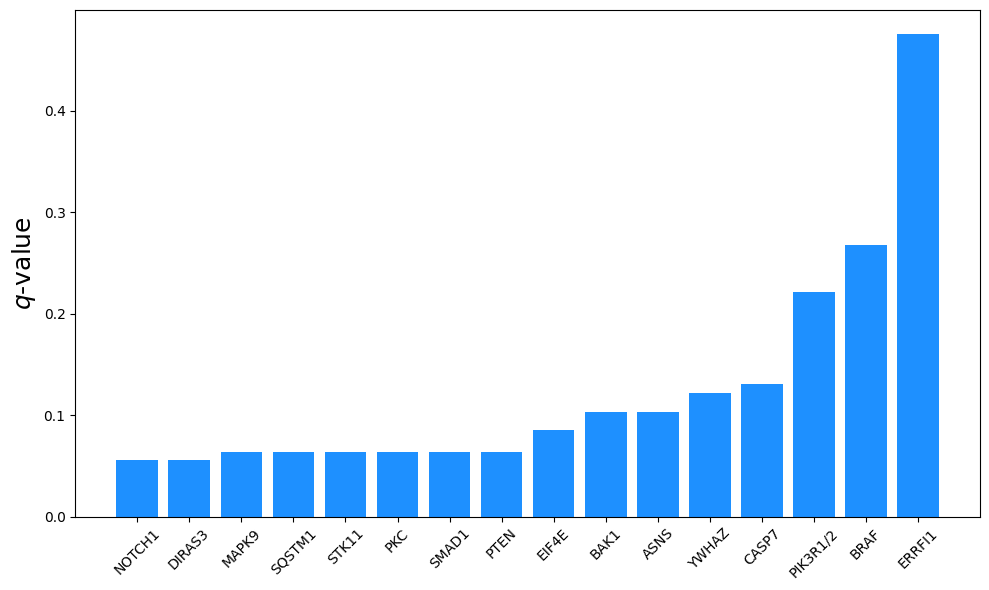

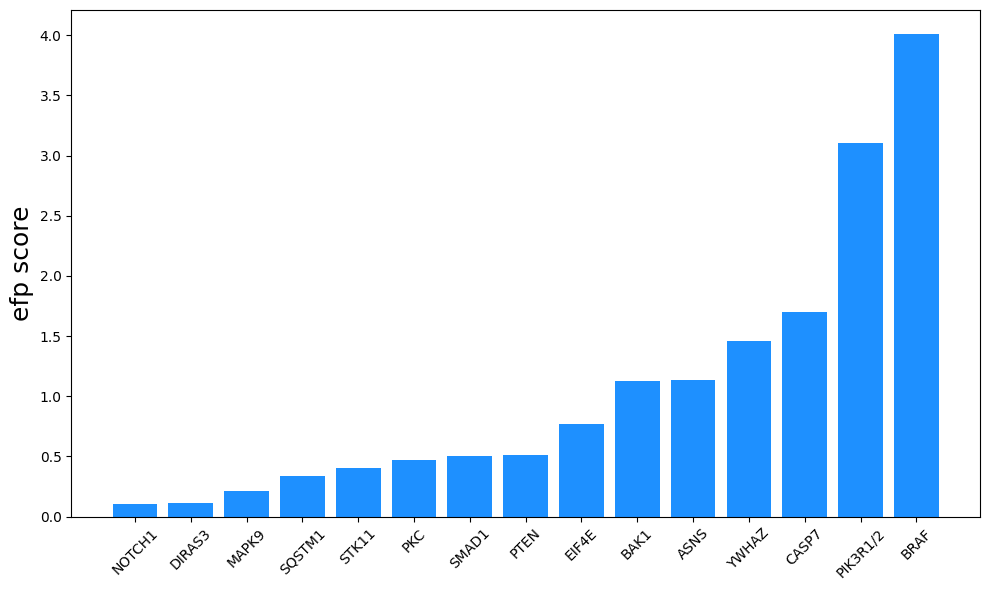

In [29]:
plot_q_values = True
plot_efp_scores = True

# plot q-values for all features with q-values below a certain threshold
if plot_q_values:
	q_value_threshold = 0.5
	q_values = ipss_output['q_values']
	q_values = [(index, q_value) for (index, q_value) in q_values if q_value <= q_value_threshold]

	plt.figure(figsize=(10, 6))
	for i, (feature_index, q_value) in enumerate(q_values):
		plt.bar(i, q_value, color='dodgerblue')
	plt.xticks(range(len(q_values)), [feature_names[feature_index] for feature_index, _ in q_values], rotation=45)
	plt.ylabel('$q$-value', fontsize=18)
	plt.tight_layout()
	plt.show()

# plot efp scores for all features with efp scores below a certain threshold
if plot_efp_scores:
	efp_score_threshold = 5
	efp_scores = ipss_output['efp_scores']
	efp_scores = [(index, q_value) for (index, q_value) in efp_scores if q_value <= efp_score_threshold]

	plt.figure(figsize=(10, 6))
	for i, (feature_index, efp_score) in enumerate(efp_scores):
		plt.bar(i, efp_score, color='dodgerblue')
	plt.xticks(range(len(efp_scores)), [feature_names[feature_index] for feature_index, _ in efp_scores], rotation=45)
	plt.ylabel('efp score', fontsize=18)
	plt.tight_layout()
	plt.show()